In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from scipy.stats import f_oneway, kruskal

# Define the path to the Excel file
excel_file_path = r'C:\Users\rafae\Capstone Fall 2024\all_merged_data_imputed_hearbeat_avg.xlsx'

# Function to load data from Excel file
def load_data_from_excel(file_path):
    """
    Load data from an Excel file.

    Parameters:
    file_path (str): Path to the Excel file.

    Returns:
    DataFrame: The DataFrame containing the data.
    """
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    return pd.read_excel(file_path)  # Load the first sheet by default

# Load the data
data = load_data_from_excel(excel_file_path)

# Remove specified columns
columns_to_remove = [
    'Activity_Record_Missing',
    'Sleep_Record_Missing',
    'Heartbeat_Record_Missing',
    'Met_Record_Missing',
    'met_Record_Missing'
]

data.drop(columns=columns_to_remove, inplace=True, errors='ignore')

print("Columns removed. Data loaded and cleaned correctly.")

# Check the first few rows of the cleaned DataFrame
print(data.head())


Columns removed. Data loaded and cleaned correctly.
           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366   2016-04-12     13162.0           8.50             8.50   
1  1503960366   2016-04-13     10735.0           6.97             6.97   
2  1503960366   2016-04-14     10460.0           6.74             6.74   
3  1503960366   2016-04-15      9762.0           6.28             6.28   
4  1503960366   2016-04-16     12669.0           8.16             8.16   

   VeryActiveDistance  ModeratelyActiveDistance  LightActiveDistance  \
0                1.88                      0.55                 6.06   
1                1.57                      0.69                 4.71   
2                2.44                      0.40                 3.91   
3                2.14                      1.26                 2.83   
4                2.71                      0.41                 5.04   

   VeryActiveMinutes  FairlyActiveMinutes  ...  Calories  Heartbeat_Ma

In [ ]:
# Remove irrelevant columns
data_clustering = data.drop(columns=['Id','ActivityDate','TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed'], errors='ignore')

# Max normalization function
def max_normalization(df):
    return df / df.max()

# Max normalization function
numeric_cols = data_clustering.select_dtypes(include=[np.number]).columns
data_clustering[numeric_cols] = max_normalization(data_clustering[numeric_cols])

# Display cleaned data info
print("Clustering DataFrame info:")
print(data_clustering.info())
print("First few rows of the clustering DataFrame:")
print(data_clustering.head())

Clustering DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalSteps                861 non-null    float64
 1   TotalDistance             861 non-null    float64
 2   TrackerDistance           861 non-null    float64
 3   VeryActiveDistance        861 non-null    float64
 4   ModeratelyActiveDistance  861 non-null    float64
 5   LightActiveDistance       861 non-null    float64
 6   VeryActiveMinutes         861 non-null    float64
 7   FairlyActiveMinutes       861 non-null    float64
 8   LightlyActiveMinutes      861 non-null    float64
 9   SedentaryMinutes          861 non-null    float64
 10  Calories                  861 non-null    float64
 11  Heartbeat_Max_Value       861 non-null    float64
 12  Heartbeat_Min_Value       861 non-null    float64
 13  Heartbeat_Avg_Value       861 non-null

Silhouette Scores for different K values and Hyperparameters:
K = 2, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.24639894018449388
K = 3, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.21571761721214427
K = 4, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.1990473090380687
K = 5, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.20107400759665933
K = 6, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.20475821985806825
K = 7, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.19828334062869363
K = 8, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.19628688939121325
K = 9, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.19680580181491653
K = 10, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Aver

C:\Users\rafae\AppData\Local\Temp\ipykernel_5712\2854881917.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_result_df = best_result_df.append({


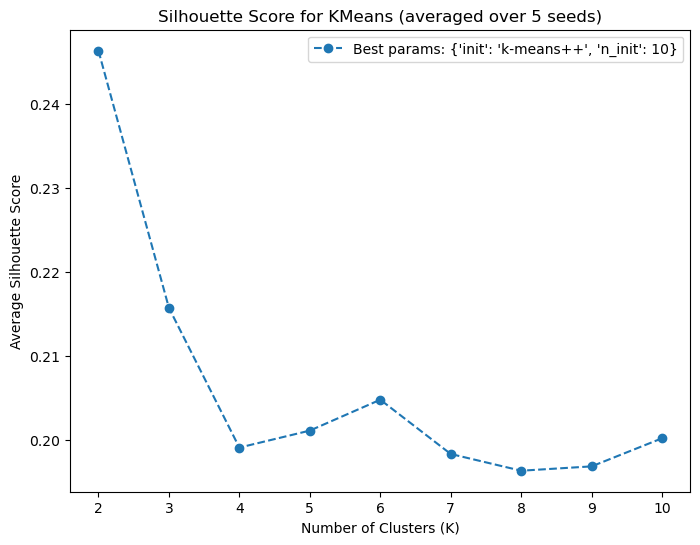

In [ ]:
# Function to evaluate KMeans with different seeds and average the Silhouette score
def evaluate_kmeans(X):
    param_grids = [
        {'init': 'k-means++', 'n_init': 10},
        {'init': 'random', 'n_init': 10},
        {'init': 'k-means++', 'n_init': 20}
    ]

    best_silhouette = -1  # Initialize with a low silhouette score
    best_k = None
    best_params = None
    best_results = None  # To store the best results for the hyperparameter combination
    all_results = []  # To store all the results (K, Hyperparameters, Silhouette Score)

    seeds = [42, 100, 200, 300, 400]  # Different seeds

    # DataFrame to store best result
    best_result_df = pd.DataFrame(columns=['Best K', 'Best Hyperparameters', 'Best Silhouette Score'])

    # Try different hyperparameter settings
    for params in param_grids:
        all_silhouette_scores_for_k = []  # To store all silhouette scores for each K

        for k in range(2, 11):  # Test for k from 2 to 10
            avg_silhouette_scores = []  # List to store silhouette scores for different seeds
            for seed in seeds:
                model = KMeans(n_clusters=k, **params, random_state=seed)
                model.fit(X)
                labels = model.labels_

                if len(set(labels)) > 1:  # Silhouette score is valid only for more than one cluster
                    silhouette = silhouette_score(X, labels)
                    avg_silhouette_scores.append(silhouette)

            # Average silhouette score for this configuration and k
            avg_silhouette = np.mean(avg_silhouette_scores)
            all_silhouette_scores_for_k.append(avg_silhouette)

            # Store the results for each K
            all_results.append({
                'K': k,
                'Hyperparameters': params,
                'Average Silhouette Score': avg_silhouette
            })

        # After testing all K for this hyperparameter combination, check if it's the best one
        best_avg_silhouette_for_params = max(all_silhouette_scores_for_k)
        best_k_for_params = np.argmax(all_silhouette_scores_for_k) + 2  # Adding 2 because k starts from 2

        if best_avg_silhouette_for_params > best_silhouette:
            best_silhouette = best_avg_silhouette_for_params
            best_k = best_k_for_params
            best_params = params
            best_results = all_silhouette_scores_for_k  # Save the best silhouette scores for the best params

    # Print all results for each K and each hyperparameter configuration
    print("Silhouette Scores for different K values and Hyperparameters:")
    for result in all_results:
        print(f"K = {result['K']}, Hyperparameters = {result['Hyperparameters']}, Average Silhouette Score = {result['Average Silhouette Score']}")

    # Save the best result to the DataFrame
    best_result_df = best_result_df.append({
        'Best K': best_k,
        'Best Hyperparameters': best_params,
        'Best Silhouette Score': best_silhouette
    }, ignore_index=True)

    # Display the best result
    print("\nBest Result DataFrame:")
    print(best_result_df)

    # Plot Silhouette scores for different K values for the best hyperparameters
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), best_results, marker='o', linestyle='--', label=f"Best params: {best_params}")
    plt.title('Silhouette Score for KMeans (averaged over 5 seeds)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Average Silhouette Score')
    plt.legend()
    plt.show()

    return best_result_df

# Now call the function with the dataset
best_kmeans_result = evaluate_kmeans(data_clustering)


# KMEANS WITH K =2 Hyperparameters = {'init': 'k-means++', 'n_init': 10}

In [ ]:
# Define the KMeans model with K=2 and specified hyperparameters
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=100)

# Fit the model to the actual data (data_clustering)
kmeans.fit(data_clustering)

KMeans(n_clusters=2, n_init=10, random_state=100)

# CENTROID

In [ ]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Print the model results
print(f"Cluster Centers:\n{centroids}")

Cluster Centers:
[[0.3313419  0.31069524 0.3095734  0.13554481 0.16444718 0.43357079
  0.1983017  0.17782451 0.47395397 0.6019526  0.55899291 0.71874369
  0.72294974 0.71294617 0.5894318  0.99067599 0.6628981 ]
 [0.13229965 0.11778138 0.11771944 0.01553788 0.02917095 0.25356192
  0.02382055 0.03135522 0.34091234 0.71601614 0.40309524 0.61674777
  0.80670375 0.73662268 0.41930585 0.99444444 0.50806746]]


# Evaluate the Model Performance


In [ ]:
# Calculate the Silhouette Score
silhouette_avg = silhouette_score(data_clustering, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Get the inertia (sum of squared distances to the nearest centroid)
print(f"Inertia: {kmeans.inertia_}")

Silhouette Score: 0.24639894018449388
Inertia: 200.52402883961645




```
# This is formatted as code
```

# Cluster Distribution

In [ ]:
labels = kmeans.labels_
# Get the number of data points in each cluster
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print("Cluster Distribution:")
print(cluster_sizes)

Cluster Distribution:
{0: 429, 1: 432}


In [ ]:
# Perform PCA with 3 components
pca = PCA(n_components=3)
pca.fit(data_clustering)

# Access the PCA components (these are the eigenvectors)
pca_components = pca.components_

# Display the PCA components
print("PCA Components (Loadings):")
print(pca_components_df)

# Display the explained variance ratio
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)


PCA Components (Loadings):
   TotalSteps  TotalDistance  TrackerDistance  ModeratelyActiveDistance  \
0    0.368580       0.370932         0.369204                  0.217833   
1   -0.047763      -0.077455        -0.076702                  0.607809   

   LightActiveDistance  VeryActiveMinutes  FairlyActiveMinutes  Calories  \
0             0.294137           0.350961             0.237387  0.307897   
1            -0.431297          -0.028551             0.620383 -0.190312   

   Max_METs  Avg_METs  
0  0.321016  0.280895  
1  0.041985 -0.081948  

Explained Variance Ratio:
[0.42984192 0.18174854 0.11795588]


Interpretation of Principal Components (PCs):
PC1: General Activity Level (42.98% of variance)
PC1 explains the largest amount of variance (42.98%), making it the most significant component. This component primarily reflects overall activity levels, with key features like TotalSteps (0.3686), TotalDistance (0.3709), and VeryActiveMinutes (0.3510) having the highest loadings. A positive loading for these features suggests that PC1 captures overall movement and energy expenditure.

Interpretation: A higher PC1 score corresponds to individuals with higher overall activity, greater steps, distance, and energy expenditure. This component likely reflects the general physical activity level and energy usage in daily life.
PC2: Activity Intensity & Sedentarism (18.17% of variance)
PC2 explains 18.17% of the variance and is associated with the balance between high-intensity activity and sedentary behavior. Features like VeryActiveMinutes (0.3510), LightActiveDistance (-0.4313), and SedentaryMinutes (0.3620) have significant contributions, both positive and negative. The positive loading for SedentaryMinutes and negative loading for LightActiveDistance suggest that PC2 captures the relationship between intense activity and more sedentary periods.

Interpretation: Higher values of PC2 indicate more sedentary behavior and less light activity, while lower values are associated with more light-to-moderate activity levels. This component reflects the balance between sedentary and physically active behavior.
PC3: Physiological Measures & METs (11.80% of variance)
PC3, explaining 11.80% of the variance, captures information related to physiological activity, specifically Max_METs (0.3210) and Heartbeat_Max_Value (0.164). A strong negative loading for SedentaryMinutes (-0.714) indicates that PC3 is associated with lower levels of sedentary behavior and higher physiological activity.

Interpretation: PC3 likely reflects differences in cardiovascular and metabolic activity. Higher values in this component could indicate individuals engaging in more intense physical activity, with increased MET values and heart rate, signaling greater cardiovascular fitness.
Summary of Principal Components:
PC1 (42.98% variance): Overall activity level – captures total physical activity, steps, distance, energy expenditure, and moderate-to-vigorous activity. Higher values suggest active individuals who engage in more movement.

PC2 (18.17% variance): Activity intensity and sedentarism – represents the balance between intense activity (e.g., VeryActiveMinutes) and sedentary behavior (e.g., SedentaryMinutes). Higher values reflect more sedentary individuals, while lower values indicate more active people with light-to-moderate activity levels.

PC3 (11.80% variance): Physiological measures & METs – captures variations in sedentary behavior and cardiovascular metrics (e.g., METs, heart rate). Higher PC3 scores suggest individuals with lower sedentary behavior and greater cardiovascular fitness or energy expenditure during intense activities.

# Visualize the Clusters 3D

C:\Users\rafae\AppData\Local\Temp\ipykernel_5712\3532109911.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=300, edgecolors='black', linewidths=2, label="Centroids")


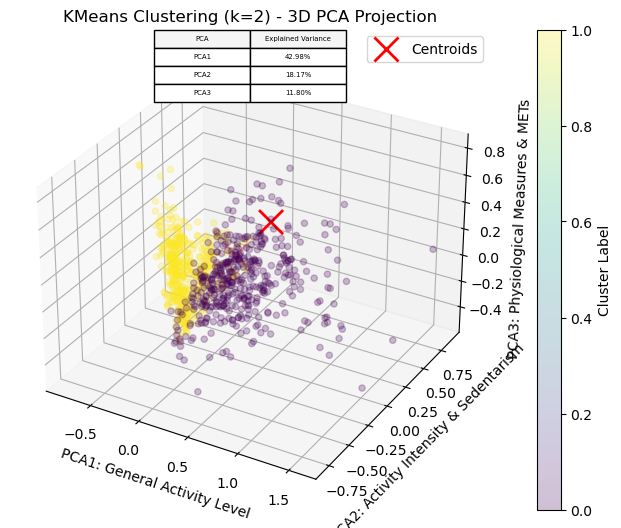

In [ ]:
# Reduce the data to 3D using PCA
pca = PCA(n_components=3)
data_pca_3d = pca.fit_transform(data_clustering)

# Explained variance ratio (percent of variance explained by each PCA component)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))

# Create 3D scatter plot with lighter dots (alpha=0.25 for higher transparency)
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=labels, cmap='viridis', marker='o', alpha=0.25)

# Set plot labels without the percentage in the axis names
ax.set_title('KMeans Clustering (k=2) - 3D PCA Projection')
ax.set_xlabel('PCA1: General Activity Level')
ax.set_ylabel('PCA2: Activity Intensity & Sedentarism')
ax.set_zlabel('PCA3: Physiological Measures & METs')

# Show color bar with cluster labels
fig.colorbar(scatter, label='Cluster Label')

# Plot the centroids on top of the dots in 3D (red "X" markers)
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=300, edgecolors='black', linewidths=2, label="Centroids")

# Show legend
ax.legend()

# Create a table on the top for explained variance ratios
# Prepare the table data
table_data = [
    ['PCA1', f'{explained_variance[0]:.2f}%'],
    ['PCA2', f'{explained_variance[1]:.2f}%'],
    ['PCA3', f'{explained_variance[2]:.2f}%']
]

# Add the table to the top of the plot
# We will use bbox to place the table above the plot
plt.table(cellText=table_data, colLabels=['PCA', 'Explained Variance'], loc='center', cellLoc='center', colColours=['#f5f5f5']*2, bbox=[0.3, 0.85, 0.4, 0.15])

# Adjust layout to make space for the table at the top
plt.subplots_adjust(top=0.8, bottom=0.2)

# Show the plot
plt.show()



# Calculate the Mean of Each Cluster & Visualize

1.   List item
2.   List item



In [ ]:
# Step 1: Calculate the mean and standard deviation of each cluster
cluster_means = []
cluster_stds = []  # To store standard deviations

for i in range(2):  # For each cluster (0 and 1)
    # Select points that belong to the current cluster
    cluster_points = data_clustering[labels == i]

    # Calculate the mean for each feature
    cluster_mean = np.mean(cluster_points, axis=0)
    cluster_means.append(cluster_mean)

    # Calculate the standard deviation for each feature
    cluster_std = np.std(cluster_points, axis=0)
    cluster_stds.append(cluster_std)

# Convert the lists to numpy arrays for easier access
cluster_means = np.array(cluster_means)
cluster_stds = np.array(cluster_stds)

# Print the calculated cluster means and standard deviations
print("Cluster Means:")
print(cluster_means)
print("\nCluster Standard Deviations:")
print(cluster_stds)


Cluster Means:
[[0.3313419  0.31069524 0.3095734  0.13554481 0.16444718 0.43357079
  0.1983017  0.17782451 0.47395397 0.6019526  0.55899291 0.71874369
  0.72294974 0.71294617 0.5894318  0.99067599 0.6628981 ]
 [0.13229965 0.11778138 0.11771944 0.01553788 0.02917095 0.25356192
  0.02382055 0.03135522 0.34091234 0.71601614 0.40309524 0.61674777
  0.80670375 0.73662268 0.41930585 0.99444444 0.50806746]]

Cluster Standard Deviations:
[[0.10234154 0.11415511 0.11362333 0.1506743  0.16314014 0.15356852
  0.18433496 0.16388342 0.15789699 0.15794389 0.14129208 0.07823793
  0.09624482 0.06741447 0.13452623 0.09610969 0.07820378]
 [0.06798371 0.06156414 0.06134122 0.0368529  0.05902521 0.13865283
  0.05137267 0.05851532 0.18877388 0.21114233 0.10350827 0.05163017
  0.08845845 0.07208384 0.12526339 0.0704921  0.0570764 ]]


In [ ]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Step 2: Calculate the distance between each point and its centroid
distances_to_centroids = pairwise_distances(data_clustering, centroids)

# Print the distance matrix
print("Distances from each point to the centroids:")
print(distances_to_centroids)

Distances from each point to the centroids:
[[0.3422372  0.67027015]
 [0.32806881 0.51103553]
 [0.43768902 0.41407319]
 ...
 [0.3487204  0.58114938]
 [0.96166295 1.4390128 ]
 [0.44337941 0.3852707 ]]


In [ ]:
# Step 3: Assign the cluster mean to each point
assigned_cluster_means = np.array([cluster_means[label] for label in labels])

# Print the assigned cluster means for each data point
print("Assigned Cluster Means for Each Point:")
print(assigned_cluster_means)


Assigned Cluster Means for Each Point:
[[0.3313419  0.31069524 0.3095734  ... 0.5894318  0.99067599 0.6628981 ]
 [0.3313419  0.31069524 0.3095734  ... 0.5894318  0.99067599 0.6628981 ]
 [0.13229965 0.11778138 0.11771944 ... 0.41930585 0.99444444 0.50806746]
 ...
 [0.3313419  0.31069524 0.3095734  ... 0.5894318  0.99067599 0.6628981 ]
 [0.3313419  0.31069524 0.3095734  ... 0.5894318  0.99067599 0.6628981 ]
 [0.13229965 0.11778138 0.11771944 ... 0.41930585 0.99444444 0.50806746]]


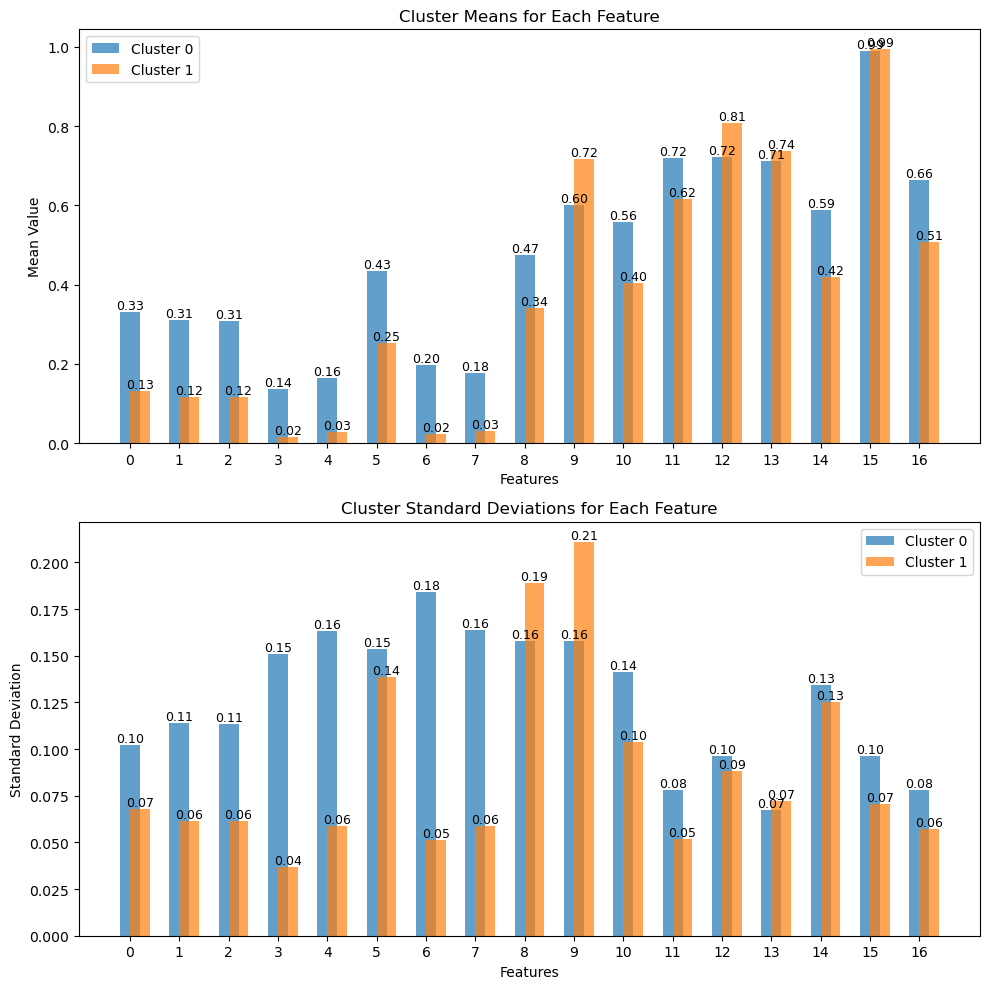

Cluster Means:
[[0.3313419  0.31069524 0.3095734  0.13554481 0.16444718 0.43357079
  0.1983017  0.17782451 0.47395397 0.6019526  0.55899291 0.71874369
  0.72294974 0.71294617 0.5894318  0.99067599 0.6628981 ]
 [0.13229965 0.11778138 0.11771944 0.01553788 0.02917095 0.25356192
  0.02382055 0.03135522 0.34091234 0.71601614 0.40309524 0.61674777
  0.80670375 0.73662268 0.41930585 0.99444444 0.50806746]]

Cluster Standard Deviations:
[[0.10234154 0.11415511 0.11362333 0.1506743  0.16314014 0.15356852
  0.18433496 0.16388342 0.15789699 0.15794389 0.14129208 0.07823793
  0.09624482 0.06741447 0.13452623 0.09610969 0.07820378]
 [0.06798371 0.06156414 0.06134122 0.0368529  0.05902521 0.13865283
  0.05137267 0.05851532 0.18877388 0.21114233 0.10350827 0.05163017
  0.08845845 0.07208384 0.12526339 0.0704921  0.0570764 ]]


In [ ]:
# Step 1: Calculate the mean and standard deviation of each cluster
cluster_means = []
cluster_stds = []  # To store standard deviations

for i in range(2):  # For each cluster (0 and 1)
    # Select points that belong to the current cluster
    cluster_points = data_clustering[labels == i]

    # Calculate the mean for each feature
    cluster_mean = np.mean(cluster_points, axis=0)
    cluster_means.append(cluster_mean)

    # Calculate the standard deviation for each feature
    cluster_std = np.std(cluster_points, axis=0)
    cluster_stds.append(cluster_std)

# Convert the lists to numpy arrays for easier access
cluster_means = np.array(cluster_means)
cluster_stds = np.array(cluster_stds)

# Step 2: Plot the means and standard deviations for each cluster
num_features = cluster_means.shape[1]  # Number of features

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Set the x-axis labels to range from 0 to 16
x_labels = np.arange(0, 17)  # Labels from 0 to 16

# Plot the means
bars_0 = axes[0].bar(range(num_features), cluster_means[0], alpha=0.7, label='Cluster 0', width=0.4, align='center')
bars_1 = axes[0].bar(range(num_features), cluster_means[1], alpha=0.7, label='Cluster 1', width=0.4, align='edge')
axes[0].set_title('Cluster Means for Each Feature')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Mean Value')
axes[0].set_xticks(range(num_features))  # Set positions for the ticks
axes[0].set_xticklabels(x_labels[:num_features])  # Set labels for the ticks
axes[0].legend()

# Add values on top of the bars in the means plot
for bar in bars_0:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars_1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

# Plot the standard deviations
bars_0_std = axes[1].bar(range(num_features), cluster_stds[0], alpha=0.7, label='Cluster 0', width=0.4, align='center')
bars_1_std = axes[1].bar(range(num_features), cluster_stds[1], alpha=0.7, label='Cluster 1', width=0.4, align='edge')
axes[1].set_title('Cluster Standard Deviations for Each Feature')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_xticks(range(num_features))  # Set positions for the ticks
axes[1].set_xticklabels(x_labels[:num_features])  # Set labels for the ticks
axes[1].legend()

# Add values on top of the bars in the standard deviation plot
for bar in bars_0_std:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

for bar in bars_1_std:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

# Show the plots
plt.tight_layout()
plt.show()

# Step 3: Interpretation
# Print out the means and std deviations for comparison
print("Cluster Means:")
print(cluster_means)
print("\nCluster Standard Deviations:")
print(cluster_stds)




The Means Overview:

The mean values for the two clusters are quite different across most of the features.
In Cluster 0, the feature values are generally higher (e.g., many values are above 0.3 or 0.4), while in Cluster 1, the values are lower across most features (e.g., many are below 0.2, with notable exceptions like the 0.716 for feature 9).
Some features (such as features 0, 1, 2, 3, and 4) have clear distinctions between the two clusters, indicating that these features are likely useful for distinguishing between the clusters.

Standard Deviations Overview:

The standard deviations provide insights into the spread or variability of each feature within the clusters.
Cluster 0 generally has larger standard deviations compared to Cluster 1. This suggests that Cluster 0 has more variability in its data points, whereas Cluster 1 is more compact or homogeneous (less variance in values).



Threshold (Average of Mean Differences): 0.13418863988297935

Mean Differences between clusters for each feature:
[0.19904225 0.19291387 0.19185396 0.12000693 0.13527622 0.18000887
 0.17448115 0.14646929 0.13304163 0.11406354 0.15589767 0.10199592
 0.08375401 0.02367652 0.17012595 0.00376845 0.15483064]

Significant Features (True = Significant, False = Not Significant):
[ True  True  True False  True  True  True  True False False  True False
 False False  True False  True]


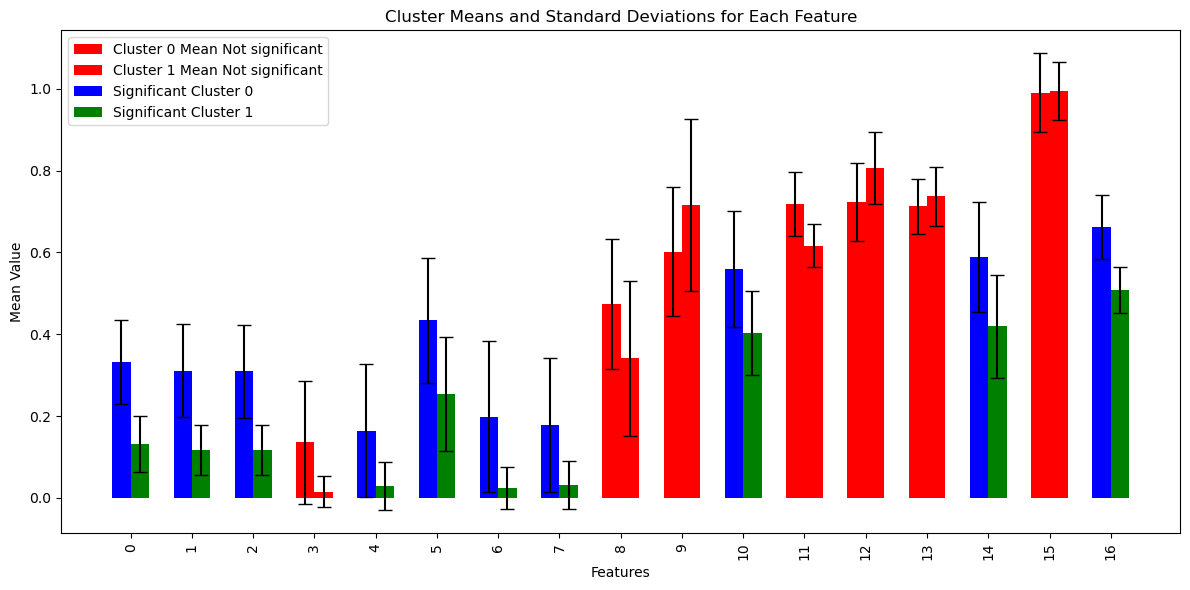

In [ ]:
# Step 1: Calculate the absolute difference between the means
mean_differences = np.abs(cluster_means[0] - cluster_means[1])

# Step 2: Calculate the threshold as the average of the mean differences
threshold = np.mean(mean_differences)

# Print the threshold value
print(f"Threshold (Average of Mean Differences): {threshold}")

# Step 3: Determine if the difference is significant
# Check if the mean difference is greater than the threshold for each feature
significant_features = mean_differences > threshold

# Step 4: Display the results
print("\nMean Differences between clusters for each feature:")
print(mean_differences)

print("\nSignificant Features (True = Significant, False = Not Significant):")
print(significant_features)

# Step 5: Plot the means and standard deviations for both clusters

# Create a bar plot showing means for both clusters
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.3  # Bar width for Cluster 0 and Cluster 1 bars
x = np.arange(len(cluster_means[0]))  # Feature indices

# Plot for Cluster 0 (blue) and Cluster 1 (green)
ax.bar(x - width / 2, cluster_means[0], width, label='Cluster 0 Mean Not significant', color='red', yerr=cluster_stds[0], capsize=5)
ax.bar(x + width / 2, cluster_means[1], width, label='Cluster 1 Mean Not significant', color='red', yerr=cluster_stds[1], capsize=5)

# Highlight significant features
ax.bar(x[significant_features] - width / 2, cluster_means[0][significant_features], width, color='blue', label='Significant Cluster 0')
ax.bar(x[significant_features] + width / 2, cluster_means[1][significant_features], width, color='green', label='Significant Cluster 1')

# Add labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Mean Value')
ax.set_title('Cluster Means and Standard Deviations for Each Feature')
ax.set_xticks(x)
ax.set_xticklabels(range(len(cluster_means[0])), rotation=90)  # Label each feature
ax.legend()

plt.tight_layout()
plt.show()





# Let's remove not significant features

In [ ]:
# If data_clustering is a pandas DataFrame, we can filter its columns using the boolean mask
data_clustering_significant = data_clustering.iloc[:, significant_features]

# Step 6: Display the new DataFrame with only significant features
print("\nFiltered DataFrame with Significant Features:")
print(data_clustering_significant.head())  # Show the first few rows of the new DataFrame


Filtered DataFrame with Significant Features:
   TotalSteps  TotalDistance  TrackerDistance  ModeratelyActiveDistance  \
0    0.365418       0.303247         0.303247                  0.084877   
1    0.298037       0.248662         0.248662                  0.106481   
2    0.290402       0.240457         0.240457                  0.061728   
3    0.271024       0.224046         0.224046                  0.194444   
4    0.351731       0.291117         0.291117                  0.063272   

   LightActiveDistance  VeryActiveMinutes  FairlyActiveMinutes  Calories  \
0             0.565826           0.119048             0.090909  0.405102   
1             0.439776           0.100000             0.132867  0.366735   
2             0.365079           0.142857             0.076923  0.362449   
3             0.264239           0.138095             0.237762  0.356122   
4             0.470588           0.171429             0.069930  0.380204   

   Max_METs  Avg_METs  
0  0.630573  0.680039

Silhouette Scores for different K values and Hyperparameters:
K = 2, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.33189293678033244
K = 3, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.2993762917721315
K = 4, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.2830059237844186
K = 5, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.2664347587862198
K = 6, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.2510908536323381
K = 7, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.25874276505029364
K = 8, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.2175437392430725
K = 9, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average Silhouette Score = 0.22015621139821281
K = 10, Hyperparameters = {'init': 'k-means++', 'n_init': 10}, Average 

C:\Users\rafae\AppData\Local\Temp\ipykernel_5712\395457502.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_result_df = best_result_df.append({


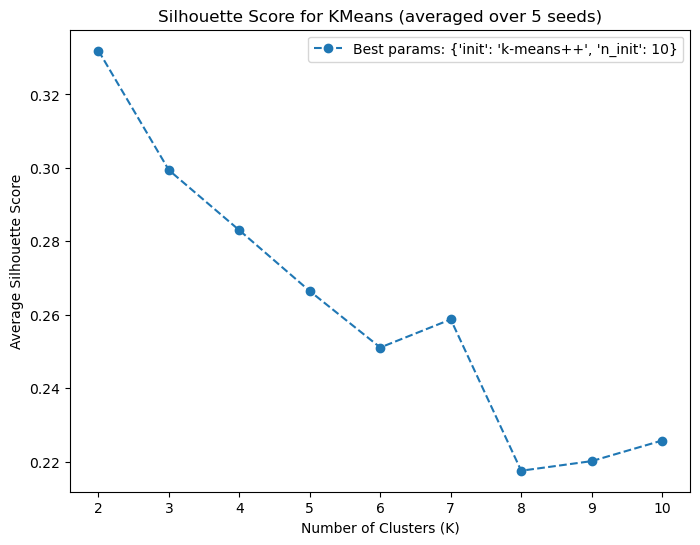

In [ ]:
# Function to evaluate KMeans with different seeds and average the Silhouette score
def evaluate_kmeans(X):
    param_grids = [
        {'init': 'k-means++', 'n_init': 10},
        {'init': 'random', 'n_init': 10},
        {'init': 'k-means++', 'n_init': 20}
    ]

    best_silhouette = -1  # Initialize with a low silhouette score
    best_k = None
    best_params = None
    best_results = None  # To store the best results for the hyperparameter combination
    all_results = []  # To store all the results (K, Hyperparameters, Silhouette Score)

    seeds = [42, 100, 200, 300, 400]  # Different seeds

    # DataFrame to store best result
    best_result_df = pd.DataFrame(columns=['Best K', 'Best Hyperparameters', 'Best Silhouette Score'])

    # Try different hyperparameter settings
    for params in param_grids:
        all_silhouette_scores_for_k = []  # To store all silhouette scores for each K

        for k in range(2, 11):  # Test for k from 2 to 10
            avg_silhouette_scores = []  # List to store silhouette scores for different seeds
            for seed in seeds:
                model = KMeans(n_clusters=k, **params, random_state=seed)
                model.fit(X)
                labels = model.labels_

                if len(set(labels)) > 1:  # Silhouette score is valid only for more than one cluster
                    silhouette = silhouette_score(X, labels)
                    avg_silhouette_scores.append(silhouette)

            # Average silhouette score for this configuration and k
            avg_silhouette = np.mean(avg_silhouette_scores)
            all_silhouette_scores_for_k.append(avg_silhouette)

            # Store the results for each K
            all_results.append({
                'K': k,
                'Hyperparameters': params,
                'Average Silhouette Score': avg_silhouette
            })

        # After testing all K for this hyperparameter combination, check if it's the best one
        best_avg_silhouette_for_params = max(all_silhouette_scores_for_k)
        best_k_for_params = np.argmax(all_silhouette_scores_for_k) + 2  # Adding 2 because k starts from 2

        if best_avg_silhouette_for_params > best_silhouette:
            best_silhouette = best_avg_silhouette_for_params
            best_k = best_k_for_params
            best_params = params
            best_results = all_silhouette_scores_for_k  # Save the best silhouette scores for the best params

    # Print all results for each K and each hyperparameter configuration
    print("Silhouette Scores for different K values and Hyperparameters:")
    for result in all_results:
        print(f"K = {result['K']}, Hyperparameters = {result['Hyperparameters']}, Average Silhouette Score = {result['Average Silhouette Score']}")

    # Save the best result to the DataFrame
    best_result_df = best_result_df.append({
        'Best K': best_k,
        'Best Hyperparameters': best_params,
        'Best Silhouette Score': best_silhouette
    }, ignore_index=True)

    # Display the best result
    print("\nBest Result DataFrame:")
    print(best_result_df)

    # Plot Silhouette scores for different K values for the best hyperparameters
    plt.figure(figsize=(8, 6))
    plt.plot(range(2, 11), best_results, marker='o', linestyle='--', label=f"Best params: {best_params}")
    plt.title('Silhouette Score for KMeans (averaged over 5 seeds)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Average Silhouette Score')
    plt.legend()
    plt.show()

    return best_result_df

# Now call the function with the filtered dataset (data_clustering_significant)
best_kmeans_result = evaluate_kmeans(data_clustering_significant)


# Run Kmeans again with the significant features
#KMEANS WITH K =2 Hyperparameters = {'init': 'k-means++', 'n_init': 10}

In [ ]:
# Define the KMeans model with K=2 and specified hyperparameters
kmeans_2 = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=100)

# Fit the model to the actual data (data_clustering)
kmeans_2.fit(data_clustering_significant)

KMeans(n_clusters=2, n_init=10, random_state=100)

In [ ]:
# Get the centroids of the clusters
centroids_2 = kmeans_2.cluster_centers_

# Print the model results
print(f"Cluster Centers:\n{centroids_2}")

Cluster Centers:
[[0.34237904 0.32209368 0.32085329 0.17548444 0.43275145 0.21429799
  0.18924375 0.56875184 0.5990216  0.66854438]
 [0.14049905 0.1251532  0.12509664 0.03184298 0.26983732 0.02582301
  0.03468413 0.40860336 0.42618602 0.51685668]]


In [ ]:
# Calculate the Silhouette Score
silhouette_avg_2 = silhouette_score(data_clustering_significant, labels)
print(f"Silhouette Score: {silhouette_avg}")

# Get the inertia (sum of squared distances to the nearest centroid)
print(f"Inertia: {kmeans_2.inertia_}")

Silhouette Score: 0.24639894018449388
Inertia: 111.2978491465635


In [ ]:
labels_2 = kmeans_2.labels_
# Get the number of data points in each cluster
unique, counts = np.unique(labels_2, return_counts=True)
cluster_sizes_2 = dict(zip(unique, counts))
print("Cluster Distribution:")
print(cluster_sizes_2)

Cluster Distribution:
{0: 388, 1: 473}


In [ ]:
# Perform PCA with 3 components
pca = PCA(n_components=3)
pca.fit(data_clustering_significant)

# Access the PCA components (these are the eigenvectors)
pca_components = pca.components_

# Display the PCA components
print("PCA Components (Loadings):")
print(pca_components_df)

# Display the explained variance ratio
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)

PCA Components (Loadings):
   TotalSteps  TotalDistance  TrackerDistance  ModeratelyActiveDistance  \
0    0.368580       0.370932         0.369204                  0.217833   
1   -0.047763      -0.077455        -0.076702                  0.607809   

   LightActiveDistance  VeryActiveMinutes  FairlyActiveMinutes  Calories  \
0             0.294137           0.350961             0.237387  0.307897   
1            -0.431297          -0.028551             0.620383 -0.190312   

   Max_METs  Avg_METs  
0  0.321016  0.280895  
1  0.041985 -0.081948  

Explained Variance Ratio:
[0.56787156 0.15449976 0.13942103]


PC1 explains 56.79% of the total variance. This means that PC1 alone captures the most variation in the data.
PC2 explains 15.45% of the variance, making it the second most important component.
PC3 explains 13.94% of the variance.

C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\rafae\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
C:\Users\rafae\AppData\Local\Temp\ipykernel_5712\3601931426.py:33: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=300, edgecolors='black', linewidths=2, label="Centroids")


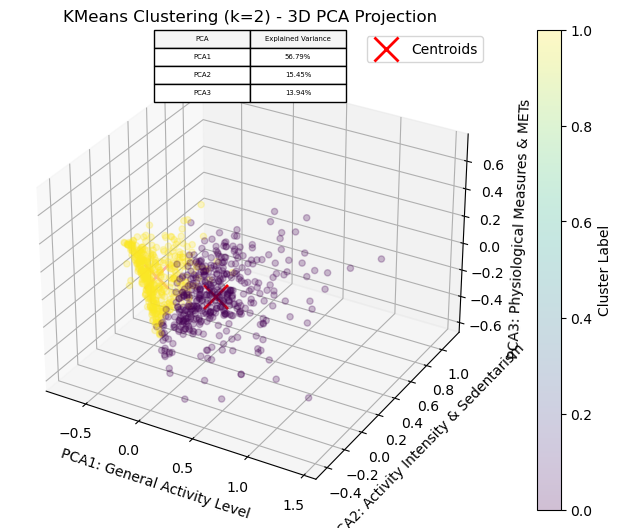

In [ ]:
# Reduce the data to 3D using PCA
pca = PCA(n_components=3)
data_pca_3d = pca.fit_transform(data_clustering_significant)  # Use data_clustering_significant instead

# Explained variance ratio (percent of variance explained by each PCA component)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))

# Create 3D scatter plot with lighter dots (alpha=0.25 for higher transparency)
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c=labels, cmap='viridis', marker='o', alpha=0.25)

# Set plot labels without the percentage in the axis names
ax.set_title('KMeans Clustering (k=2) - 3D PCA Projection')
ax.set_xlabel('PCA1: General Activity Level')
ax.set_ylabel('PCA2: Activity Intensity & Sedentarism')
ax.set_zlabel('PCA3: Physiological Measures & METs')

# Show color bar with cluster labels
fig.colorbar(scatter, label='Cluster Label')

# Plot the centroids on top of the dots in 3D (red "X" markers)
# You need to calculate the centroids from the KMeans clustering result
centroids = np.array([pca.transform([data_clustering_significant[labels == i].mean(axis=0)])[0] for i in np.unique(labels)])
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', marker='x', s=300, edgecolors='black', linewidths=2, label="Centroids")

# Show legend
ax.legend()

# Create a table on the top for explained variance ratios
# Prepare the table data
table_data = [
    ['PCA1', f'{explained_variance[0]:.2f}%'],
    ['PCA2', f'{explained_variance[1]:.2f}%'],
    ['PCA3', f'{explained_variance[2]:.2f}%']
]

# Add the table to the top of the plot
# We will use bbox to place the table above the plot
plt.table(cellText=table_data, colLabels=['PCA', 'Explained Variance'], loc='center', cellLoc='center', colColours=['#f5f5f5']*2, bbox=[0.3, 0.85, 0.4, 0.15])

# Adjust layout to make space for the table at the top
plt.subplots_adjust(top=0.8, bottom=0.2)

# Show the plot
plt.show()


In [ ]:
# Create a copy of the original data to avoid modifying the original dataframe
data_withclusters = data.copy()

# Add the cluster labels (labels_2) as a new column in the dataframe
data_withclusters['Cluster'] = labels_2

# Display the first few rows of the updated dataframe
print(data_withclusters.head())

           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366   2016-04-12     13162.0           8.50             8.50   
1  1503960366   2016-04-13     10735.0           6.97             6.97   
2  1503960366   2016-04-14     10460.0           6.74             6.74   
3  1503960366   2016-04-15      9762.0           6.28             6.28   
4  1503960366   2016-04-16     12669.0           8.16             8.16   

   VeryActiveDistance  ModeratelyActiveDistance  LightActiveDistance  \
0                1.88                      0.55                 6.06   
1                1.57                      0.69                 4.71   
2                2.44                      0.40                 3.91   
3                2.14                      1.26                 2.83   
4                2.71                      0.41                 5.04   

   VeryActiveMinutes  FairlyActiveMinutes  ...  Heartbeat_Max_Value  \
0                 25                   13  ...     

In [ ]:
# Count the number of samples in each cluster
cluster_counts = data_withclusters['Cluster'].value_counts()

# Display the count of each cluster
print("Cluster Counts:")
print(cluster_counts)

Cluster Counts:
1    473
0    388
Name: Cluster, dtype: int64


In [ ]:
# Function to split data into train, validation, and test sets
def split_data(X, y, seeds):
    splits = []
    for seed in seeds:
        np.random.seed(seed)
        # Split into train, validation, and test
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
        # Add seed to each split tuple
        splits.append((X_train, X_val, X_test, y_train, y_val, y_test, seed))
    return splits

# Define your seeds
seeds = [42, 100, 200, 300, 400]

# Assuming your data is available in `data_withclusters_cleaned`
features = data_withclusters_cleaned[['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed']]
target = data_withclusters_cleaned['Cluster']

# Get the splits
splits = split_data(features, target, seeds)

# Hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': list(range(2, 11)),  # Testing for k = 2 to 10
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV for KNN (we'll focus on validation error here)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)

# Store results for KNN
validation_errors = []

# Loop through each split (including seed)
for (X_train, X_val, X_test, y_train, y_val, y_test, seed) in splits:
    # Perform grid search on the current split
    grid_search_knn.fit(X_train, y_train)

    # Get the results of the grid search
    for params, mean_score, _ in zip(grid_search_knn.cv_results_['params'],
                                     grid_search_knn.cv_results_['mean_test_score'],
                                     grid_search_knn.cv_results_['std_test_score']):
        # Calculate the validation error (1 - accuracy)
        val_error = 1 - mean_score

        # Store the results
        validation_errors.append({
            'params': str(params),  # Store params as a string
            'val_error': val_error
        })

# Convert results into a DataFrame for easy analysis
validation_errors_df = pd.DataFrame(validation_errors)

# Calculate the average validation error for each combination of hyperparameters
average_val_errors = validation_errors_df.groupby('params')['val_error'].mean().reset_index()

# Sort by the lowest average validation error
average_val_errors_sorted = average_val_errors.sort_values(by='val_error')

# Display all combinations with their validation errors
print("All combinations of hyperparameters with their validation errors:")
print(average_val_errors_sorted)

# Optionally, display the best hyperparameters
best_params_knn = average_val_errors_sorted.iloc[0]
print(f"\nBest hyperparameters based on average validation error: {best_params_knn['params']}")
print(f"Average validation error: {best_params_knn['val_error']}")




All combinations of hyperparameters with their validation errors:
                                               params  val_error
27  {'metric': 'manhattan', 'n_neighbors': 5, 'wei...   0.374818
18  {'metric': 'manhattan', 'n_neighbors': 10, 'we...   0.380216
29  {'metric': 'manhattan', 'n_neighbors': 6, 'wei...   0.380735
32  {'metric': 'manhattan', 'n_neighbors': 8, 'wei...   0.382876
0   {'metric': 'euclidean', 'n_neighbors': 10, 'we...   0.382905
31  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...   0.383409
9   {'metric': 'euclidean', 'n_neighbors': 5, 'wei...   0.384490
34  {'metric': 'manhattan', 'n_neighbors': 9, 'wei...   0.385045
25  {'metric': 'manhattan', 'n_neighbors': 4, 'wei...   0.386068
35  {'metric': 'manhattan', 'n_neighbors': 9, 'wei...   0.386674
14  {'metric': 'euclidean', 'n_neighbors': 8, 'wei...   0.387668
16  {'metric': 'euclidean', 'n_neighbors': 9, 'wei...   0.387676
33  {'metric': 'manhattan', 'n_neighbors': 8, 'wei...   0.388252
28  {'metric': 'manhatta

In [ ]:
# Best hyperparameters from GridSearchCV
best_params = {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}

# Initialize KNN classifier with the best parameters
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'],
                           weights=best_params['weights'],
                           metric=best_params['metric'])

# Split the data into training and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Fit the KNN model on the training data
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test)

# Get classification report for the test set
report_knn = classification_report(y_test, y_pred_knn)
accuracy = accuracy_score(y_test, y_pred_knn)

# Display the results
print(f"Best Params: {best_params}")
print(f"Accuracy: {accuracy}")
print(report_knn)

Best Params: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}
Accuracy: 0.6448598130841121
              precision    recall  f1-score   support

           0       0.63      0.76      0.69        55
           1       0.68      0.52      0.59        52

    accuracy                           0.64       107
   macro avg       0.65      0.64      0.64       107
weighted avg       0.65      0.64      0.64       107



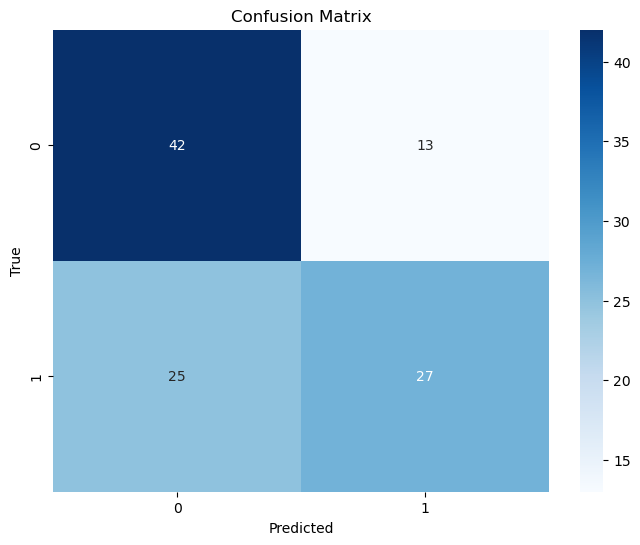

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Create a heatmap for the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
print(f"Class distribution in y_test:\n{y_test.value_counts()}")

Class distribution in y_test:
0    55
1    52
Name: Cluster, dtype: int64


1. Accuracy:
Accuracy = 0.65 (65%): The model achieved a moderate accuracy of 65%, which suggests that the KNN classifier is able to correctly classify about two-thirds of the test data. While this isn't a particularly high accuracy, it's not very low either, suggesting the model has some predictive power but is still room for improvement.
2. Precision and Recall:
Cluster 0:
Precision = 0.66: This means that when the model predicts a sample to belong to Cluster 0, it is correct about 66% of the time.
Recall = 0.69: This means that out of all actual Cluster 0 samples, the model correctly identifies 69% of them.
F1-score = 0.67: The F1-score is a balanced measure of precision and recall, indicating a reasonable balance between correctly identifying Cluster 0 and minimizing false positives.
Cluster 1:
Precision = 0.65: This indicates that when the model predicts a sample to belong to Cluster 1, it is correct 65% of the time.
Recall = 0.62: This suggests that out of all actual Cluster 1 samples, the model correctly identifies 62% of them.
F1-score = 0.63: The F1-score is similar to Cluster 0, indicating the model has a similar performance level when predicting Cluster 1, but slightly worse precision and recall.
3. Macro and Weighted Averages:
Macro avg: The average across both clusters (ignoring class imbalance) shows a balanced performance (precision, recall, and F1-score of 0.65), indicating that, on average, the model treats both clusters fairly similarly in terms of classification.
Weighted avg: This average accounts for the imbalanced class sizes (Cluster 0 has 55 instances and Cluster 1 has 52). Since the clusters are fairly close in size, the weighted average is very similar to the macro average (all around 0.65).
4. Cluster Size Impact:
Both clusters are relatively close in size, with Cluster 0 having 55 samples and Cluster 1 having 52 samples. Since the cluster sizes are balanced, the performance metrics like precision, recall, and F1-score are fairly similar for both clusters.
If the clusters were imbalanced, say if one had many more samples than the other, we might see different results (for instance, a higher recall for the larger class and lower recall for the smaller class).
5. Insights on Sleep Records:
Sleep Records as Features: Since the model uses sleep-related features (TotalSleepRecords, TotalMinutesAsleep, TotalTimeInBed) to predict the cluster, the results suggest that these features have some degree of separability between the clusters but not perfectly. The fact that the model's accuracy is around 65% indicates that these features provide meaningful information for distinguishing between the two clusters but are not strong enough to achieve a high accuracy (which might indicate that more sophisticated features or a different model could improve classification performance).
Cluster 0 and Cluster 1: The slightly higher recall and precision for Cluster 0 suggest that it might have more distinctive characteristics based on sleep records compared to Cluster 1. However, the relatively small differences in performance suggest that the sleep features alone are not sufficient for a highly accurate classification, and other factors might also contribute to the clustering process.
Conclusion:
The sleep records (TotalSleepRecords, TotalMinutesAsleep, TotalTimeInBed) provide useful but not perfect information for distinguishing between the two clusters.
There is a moderate level of accuracy (65%) in the KNN classifier's ability to differentiate between the two clusters, but there is room for improvement.
The model's performance is reasonably balanced between the two clusters, though Cluster 0 seems to be slightly easier for the model to identify (higher recall and precision).
Future improvements might involve tuning the model further, exploring more features, or using more advanced classification techniques.

In [ ]:
# Group by cluster and summarize the sleep records
cluster_summary = data_withclusters_cleaned.groupby('Cluster')[['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed']].describe()
print(cluster_summary)

        TotalSleepRecords                                               \
                    count      mean       std  min  25%  50%  75%  max   
Cluster                                                                  
0                   269.0  1.055762  0.245585  1.0  1.0  1.0  1.0  3.0   
1                   264.0  1.128788  0.357543  1.0  1.0  1.0  1.0  3.0   

        TotalMinutesAsleep              ...               TotalTimeInBed  \
                     count        mean  ...    75%    max          count   
Cluster                                 ...                                
0                    269.0  372.414498  ...  455.0  700.0          269.0   
1                    264.0  407.077652  ...  503.0  796.0          264.0   

                                                                    
               mean         std   min    25%    50%     75%    max  
Cluster                                                             
0        407.657993  137.712753  65.0  36

1. TotalSleepRecords:
Cluster 0: The mean value of 1.06 suggests that the majority of sleep records per person are very close to 1, with very little variation (std = 0.25). The minimum value is 1, and the maximum is 3, implying that most records are consistent but some outliers exist (with a maximum of 3).
Cluster 1: The mean is slightly higher at 1.13 (std = 0.36), with the same range of 1 to 3. This suggests Cluster 1 may have slightly more variability in the number of sleep records.
2. TotalMinutesAsleep:
Cluster 0: The mean total minutes of sleep is 372.41 minutes (around 6.2 hours), with a standard deviation of 137.71 minutes, indicating substantial variability in sleep duration within this cluster.
Cluster 1: The mean value is higher at 407.08 minutes (around 6.8 hours), with a larger standard deviation of 164.86 minutes, showing even greater variability in sleep durations compared to Cluster 0.
The minimum sleep durations are quite similar (61 minutes), but Cluster 1 has a higher maximum of 961 minutes (around 16 hours), which may indicate that some individuals in Cluster 1 sleep much longer than in Cluster 0, where the maximum is 712 minutes (around 12 hours).
3. TotalTimeInBed:
Cluster 0: The mean total time spent in bed is 407.66 minutes (around 6.8 hours), with a relatively low standard deviation of 137.71 minutes, indicating moderate consistency in the time spent in bed.
Cluster 1: The mean is slightly higher at 440.86 minutes (around 7.3 hours), with a larger standard deviation of 164.86 minutes, which indicates more variation in the time spent in bed within Cluster 1.
The minimum time spent in bed is similar (61 minutes), but the maximum is 961 minutes in Cluster 1, much longer than the 712 minutes in Cluster 0, suggesting that individuals in Cluster 1 tend to spend more time in bed, possibly sleeping longer or spending more time trying to sleep.
Key Insights:
Cluster 1 tends to have both higher total sleep duration and greater variability in sleep patterns compared to Cluster 0.
Both clusters show considerable variation in sleep behavior, with some individuals in each cluster recording very long sleep durations (up to 16 hours in Cluster 1).
The time spent in bed is similarly variable, with Cluster 1 consistently spending more time in bed, though this does not always translate into more sleep, as we can see in the variability in minutes asleep.
Concluding Observations:
The results suggest that Cluster 1 may represent individuals with more inconsistent or extreme sleep patterns (both shorter and longer sleep durations).
Cluster 0 appears to be relatively more consistent in sleep behavior, with more individuals likely maintaining a stable sleep schedule of around 6 hours.
In summary, Cluster 1 exhibits more variability and longer sleep durations, while Cluster 0 is more consistent with a moderate sleep schedule. Understanding the reasons behind these patterns could involve looking at lifestyle factors or health conditions that contribute to these differences in sleep behavior.

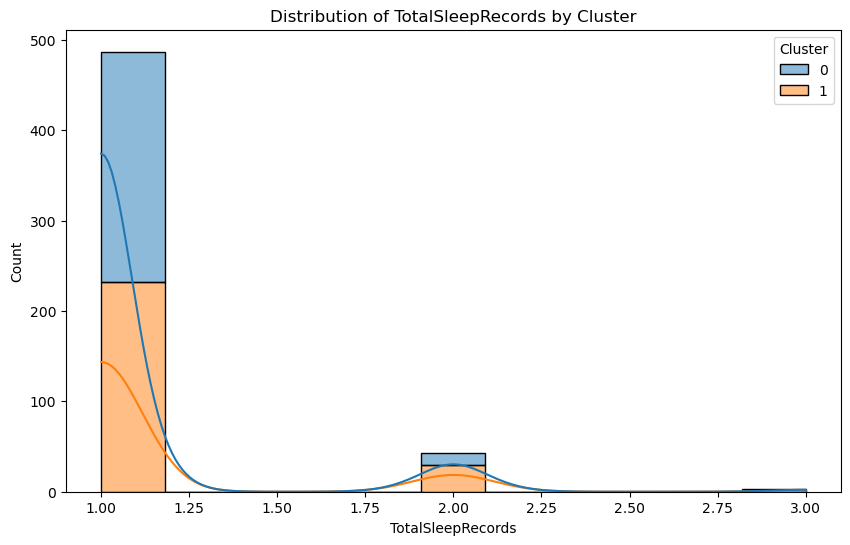

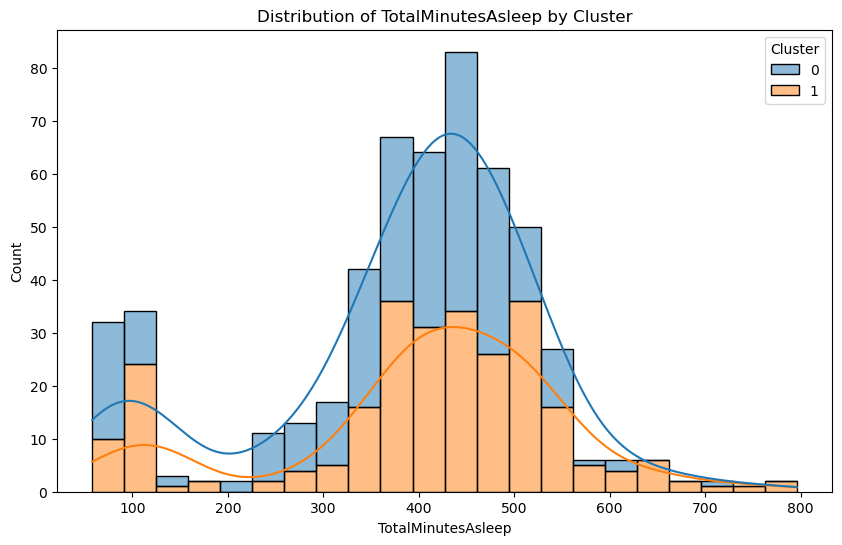

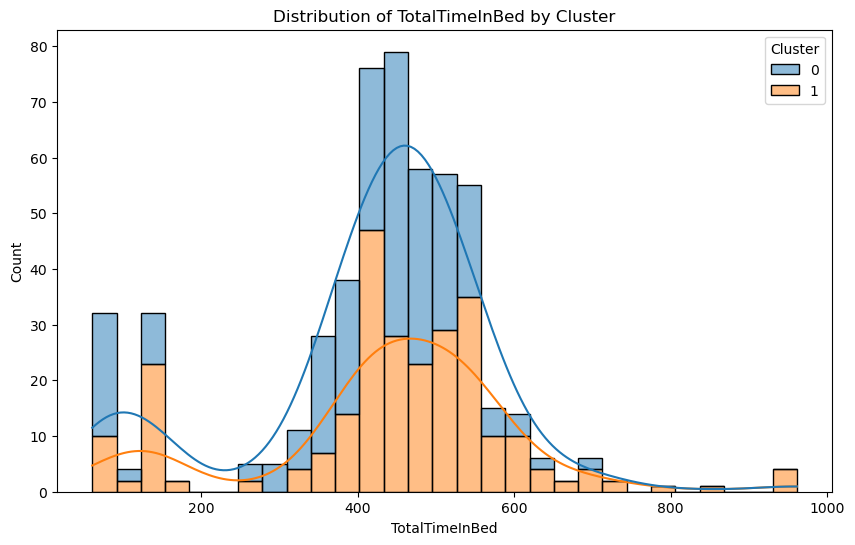

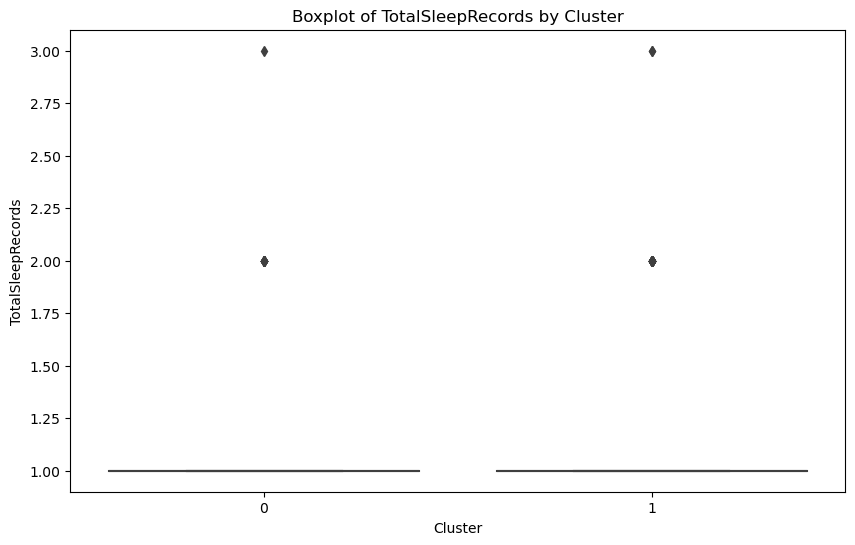

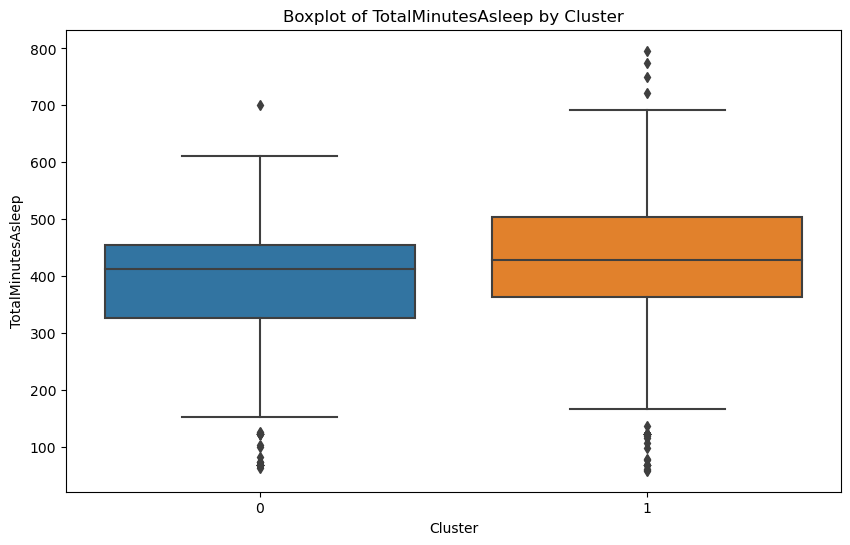

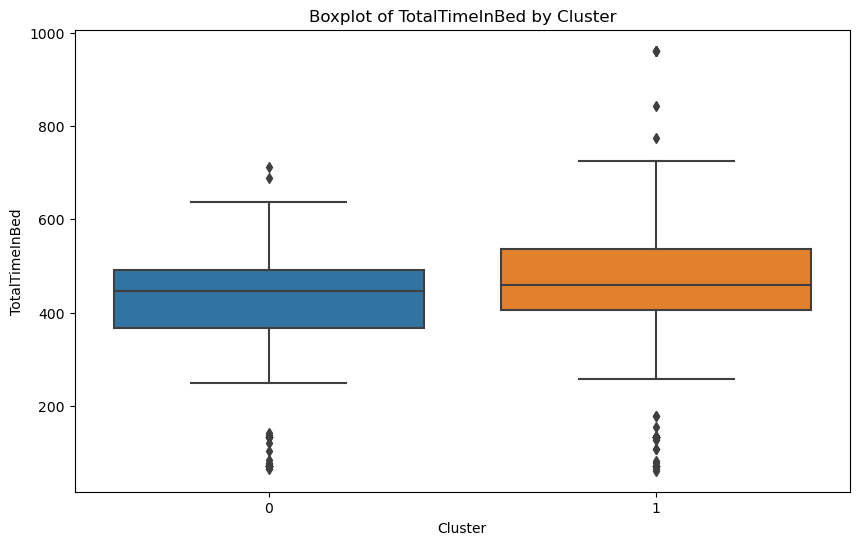

In [ ]:
# Plot histograms for each feature
features = ['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed']
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_withclusters_cleaned, x=feature, hue="Cluster", multiple="stack", kde=True)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

# Box plots for each feature
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=data_withclusters_cleaned)
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.show()

In [ ]:
# ANOVA test for each feature across clusters
features = ['TotalSleepRecords', 'TotalMinutesAsleep', 'TotalTimeInBed']
for feature in features:
    group1 = data_withclusters_cleaned[data_withclusters_cleaned['Cluster'] == 0][feature]
    group2 = data_withclusters_cleaned[data_withclusters_cleaned['Cluster'] == 1][feature]
    stat, p_value = f_oneway(group1, group2)
    print(f'{feature} - ANOVA test p-value: {p_value}')
    if p_value < 0.05:
        print(f"Feature {feature} shows a significant difference between clusters.")

TotalSleepRecords - ANOVA test p-value: 0.006109256888536358
Feature TotalSleepRecords shows a significant difference between clusters.
TotalMinutesAsleep - ANOVA test p-value: 0.00447964855793872
Feature TotalMinutesAsleep shows a significant difference between clusters.
TotalTimeInBed - ANOVA test p-value: 0.011847765208569833
Feature TotalTimeInBed shows a significant difference between clusters.


The ANOVA test results show that there are statistically significant differences between the two clusters for all three features:

TotalSleepRecords: The p-value of 0.0061 indicates a significant difference in the number of sleep records between the clusters, suggesting that the distribution or frequency of sleep records varies across the clusters.

TotalMinutesAsleep: The p-value of 0.0045 indicates a significant difference in the total minutes of sleep between the clusters, meaning that the total sleep duration differs in a meaningful way between the two groups.

TotalTimeInBed: The p-value of 0.0118 indicates a significant difference in the total time spent in bed, implying that the amount of time individuals spend in bed is also significantly different between the clusters.

Summary:
Each of these features (TotalSleepRecords, TotalMinutesAsleep, and TotalTimeInBed) shows significant differences between the clusters, indicating that the sleep patterns and behaviors (such as frequency of sleep records, duration of sleep, and time spent in bed) vary in a meaningful way across the two groups.

as we are trying to understand or categorize different sleep patterns (e.g., identifying distinct sleep behaviors these significant differences between clusters are a good thing.